# Exploratory Data Analysis

### Importing the libraries 

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from random import seed
from random import random
import warnings
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#set style for all plots
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
sns.mpl.rc("figure",figsize=(10,5))

### Reading the dataset 

In [8]:
df = pd.DataFrame(pd.read_csv("/Users/simonegenetin/Documents/YNC/Y2S2/DS Accelerator/FORECASTING/train.csv"))
#entire df has no null values
print (df.isnull().sum().sum())
#note that the last date in df is d_1919
df.head(3)

0


,id,item_id,subcat_id,category_id,store_id,region_id,d_1,d_2,d_3,d_4,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,Beauty_1_001,Beauty_1,Beauty,East_1,East,0,0,0,0,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,Beauty_1_002,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,Beauty_1_003,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,1,1,1,0,0,1,1,0,2


In [10]:
calendar = pd.DataFrame(pd.read_csv("/Users/simonegenetin/Documents/YNC/Y2S2/DS Accelerator/FORECASTING/calendar.csv"))
#note that the last date in calendar is d _1969
print(calendar.tail(3))
#We only need the first 1919 rows of calendar because beyond that there is no corresponding data in df
calendar = calendar[:1919]
#Drop the wm_yr_wk, wday, month year since we have the "date" and "weekday" columns
calendar = calendar.drop(calendar.columns[np.r_[1,3:6]], axis = 1)
#format the date in datetime
format = '%Y-%m-%d'
calendar['date'] = pd.to_datetime(calendar.date, format=format)
print(calendar.head(3))
#check the type
print(type(calendar['date'][0]))


            date  wm_yr_wk   weekday  wday  month  year       d
1966  2016-06-17     11620    Friday     7      6  2016  d_1967
1967  2016-06-18     11621  Saturday     1      6  2016  d_1968
1968  2016-06-19     11621    Sunday     2      6  2016  d_1969
        date   weekday    d
0 2011-01-29  Saturday  d_1
1 2011-01-30    Sunday  d_2
2 2011-01-31    Monday  d_3
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Group the data
We write afunction to aggregate data by categories and append calendar dates

In [11]:

def agg_and_date (df, cat, method):
    if method == "sum":
        #aggregate sales by cat. take the sum
        subdf = df.groupby(by=cat).sum().transpose()
    elif method == "mean":
        #take the mean
        subdf = df.groupby(by=cat).mean().transpose()
    else:
        raise Exception()
    #concatenate calendar information with subdf
    subdf.reset_index( drop=True, inplace=True)
    calendar.reset_index( drop=True, inplace=True)
    subdf = pd.concat([subdf, calendar.date], axis = 1, ignore_index= False)
    subdf.set_index('date', inplace = True)
    return subdf

## Visualize Time Series
The total sales across subcategories and stores all exhibit an upward trend.
Every year during Christmas, the sales of all subcategories and stores drop to near 0, possibly due to stores closing or shorter hours.
### By store

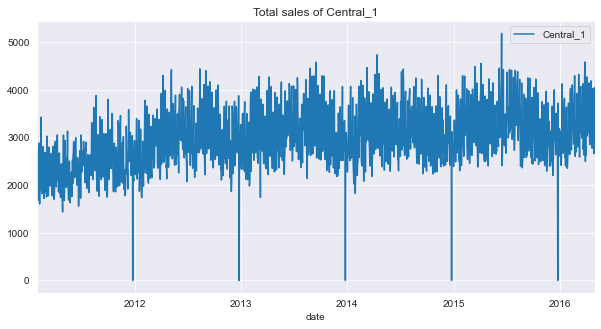

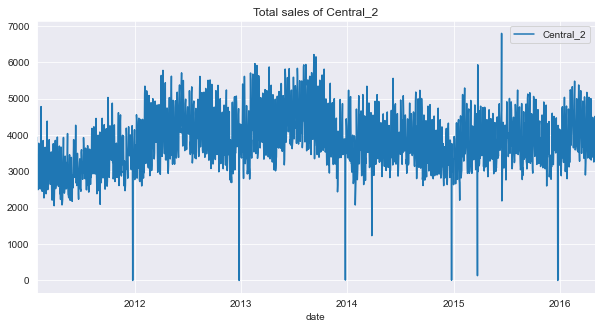

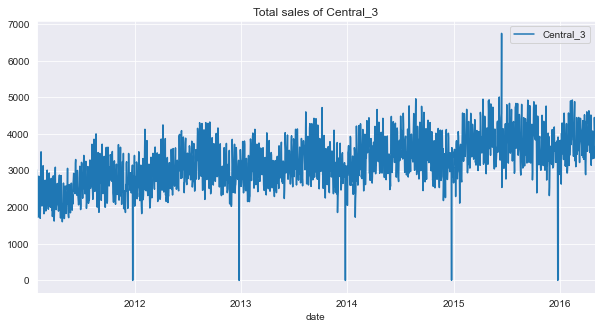

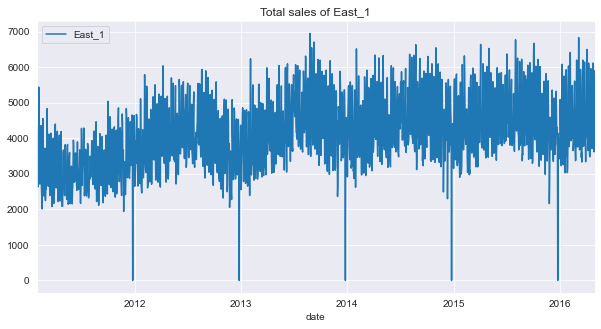

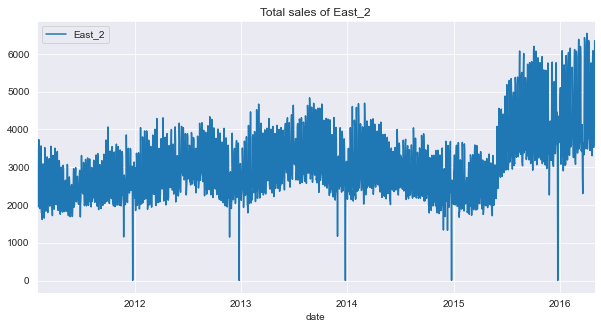

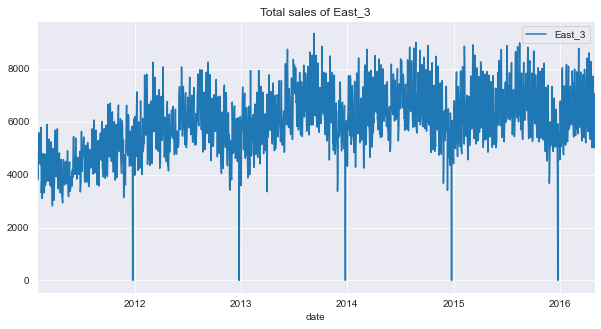

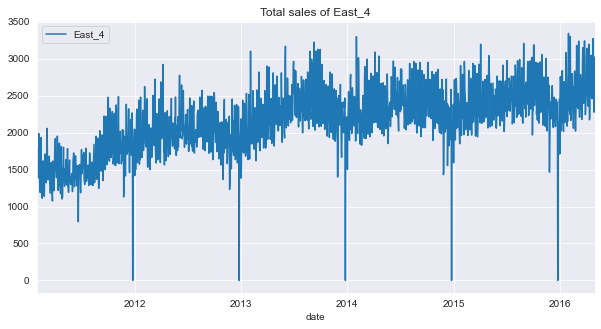

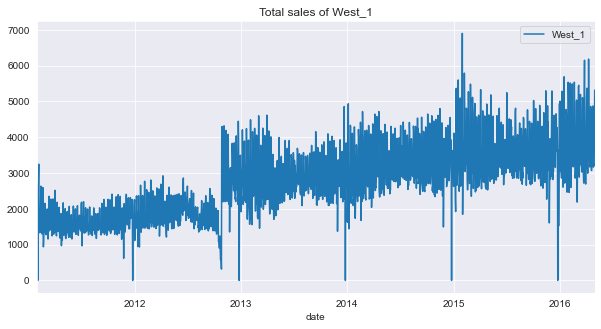

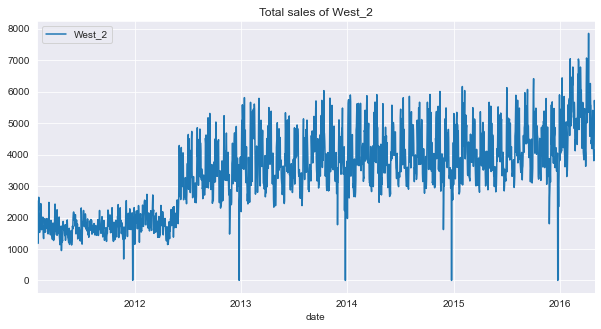

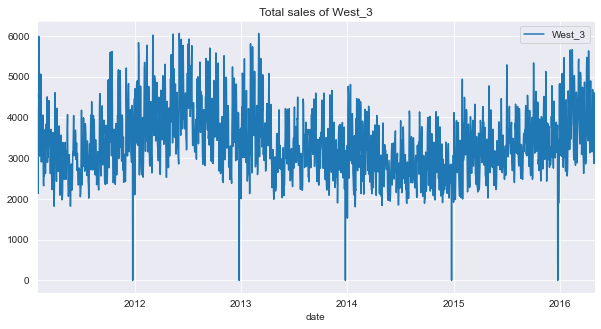

In [12]:
store = agg_and_date (df, "store_id", "sum")
for c in store.columns:
    store.plot(y = [c])
    plt.title(str("Total sales of "+c))

### By subcategory

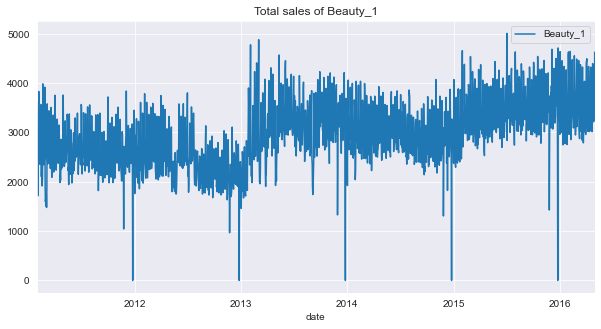

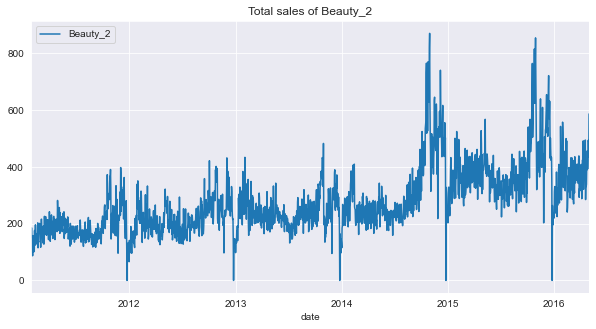

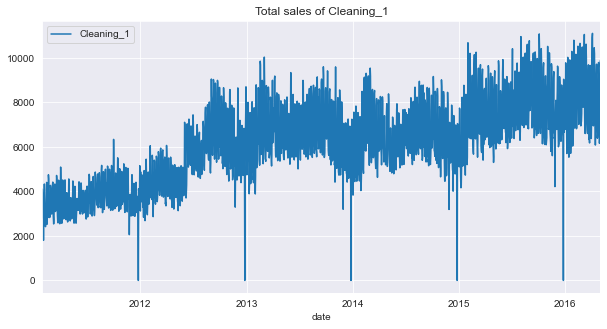

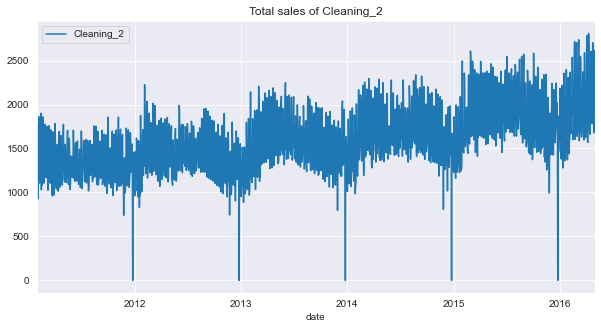

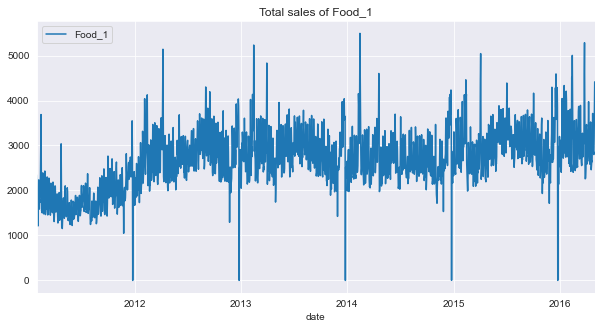

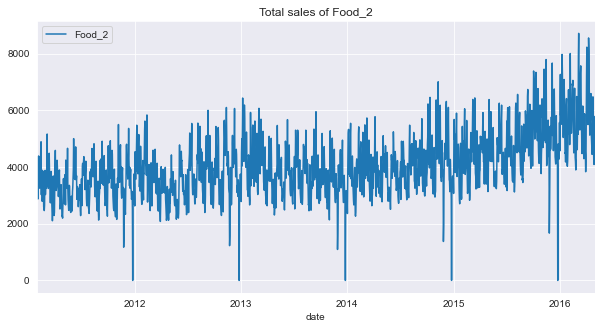

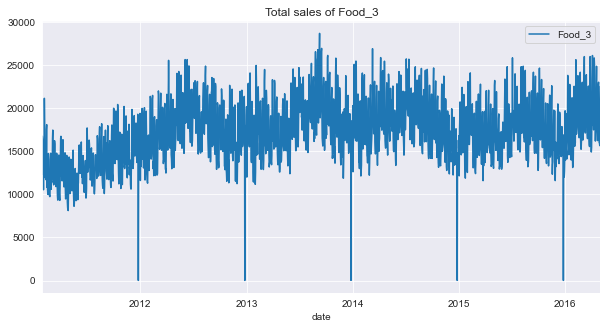

In [13]:
subcat = agg_and_date (df, "subcat_id", "sum")
for c in subcat.columns:
    subcat.plot(y = [c])
    plt.title(str("Total sales of "+c))

## Decomposition Plots
The plots show that most subcategories and stores experience fluctuations in sales at the end of the last quarter till early first quarter. Possibly because it's the holiday and sales season.

Looking at the trend plot we can say that the trend component of our time series is additive damped, as the growing trends generally stablise after 2014.
The seasonal component is additive because the amplitude of change does not increase or decrease over time

The trends by stores appear more stable than the trends by subcategories. This means that if we want to create natural clusters, we will choose store rather than subcategoreis.

### By Subcategories
Food2 and Food3 have clear monthly cycles

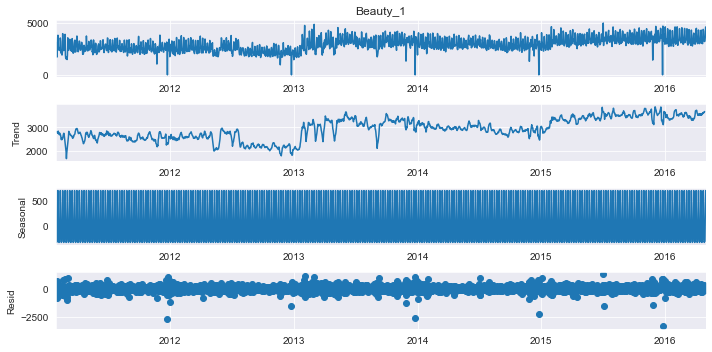

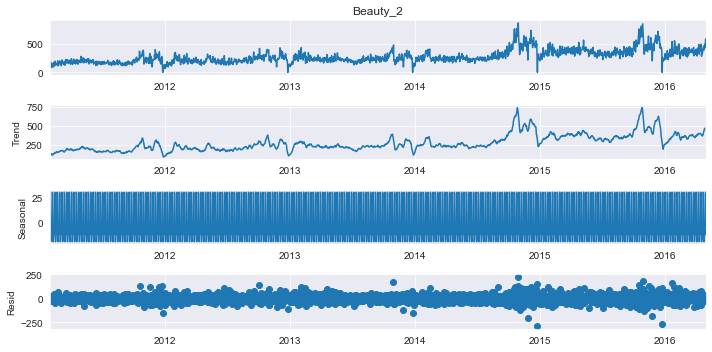

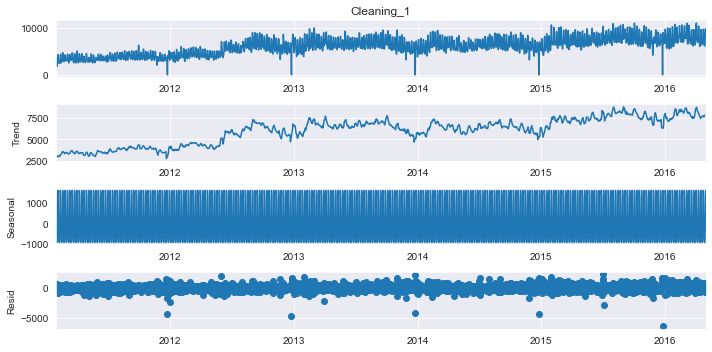

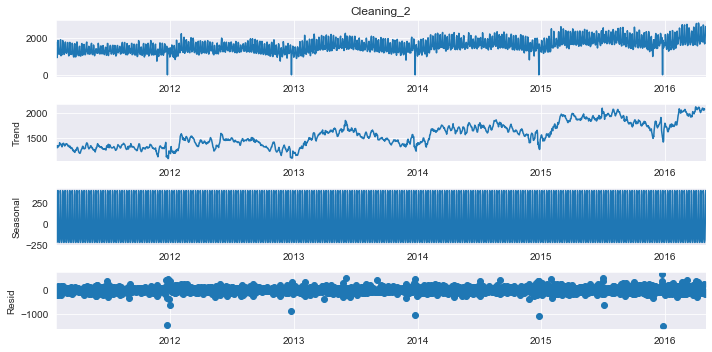

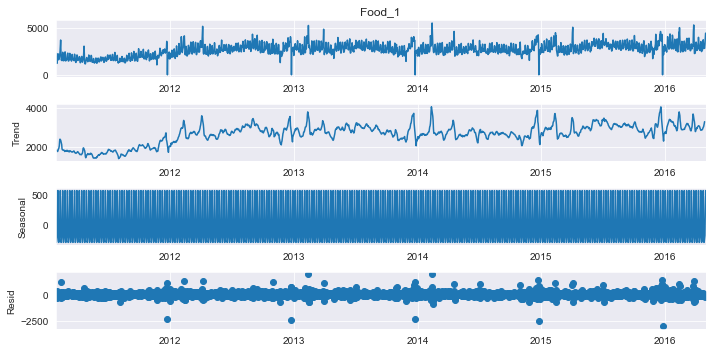

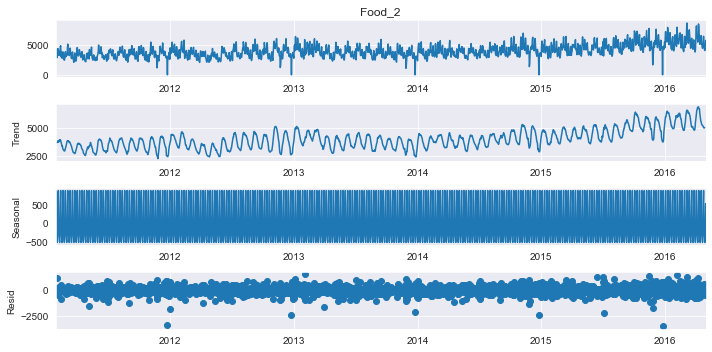

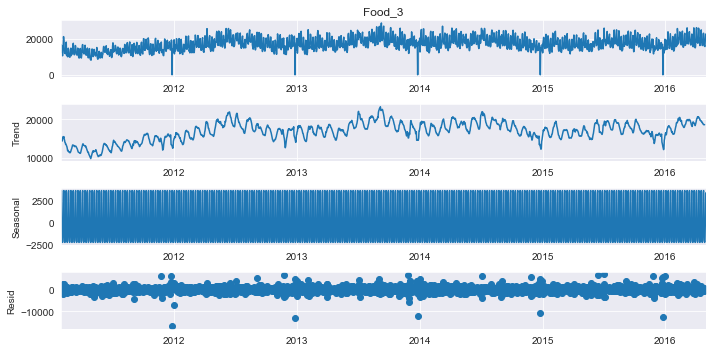

In [14]:
for c in subcat.columns:
   decomposition = sm.tsa.seasonal_decompose(
      subcat[c], model="additive")
   decomposition.plot()

The above plots also show that some trends are sub_category or region specific. For example, 'Food_1' items are bougght in higher relative quantitites right before winter festivities, while the same trend is only partially mirrored, or completely absent, in other subcategories.

### By stores

Most stores have a montly cycle

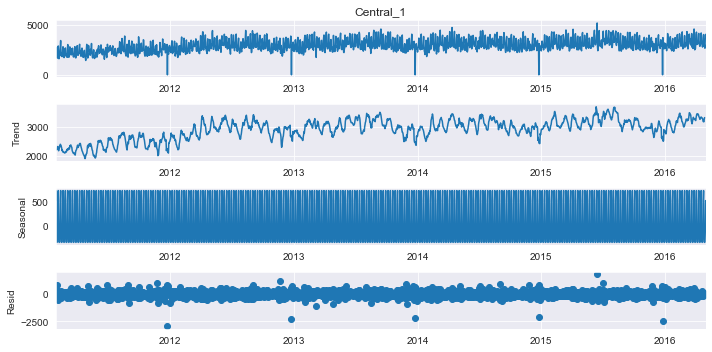

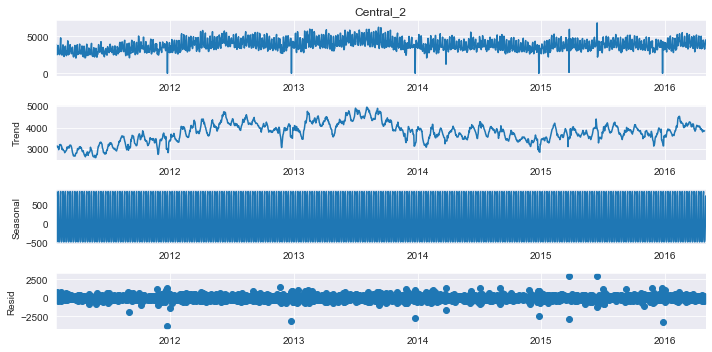

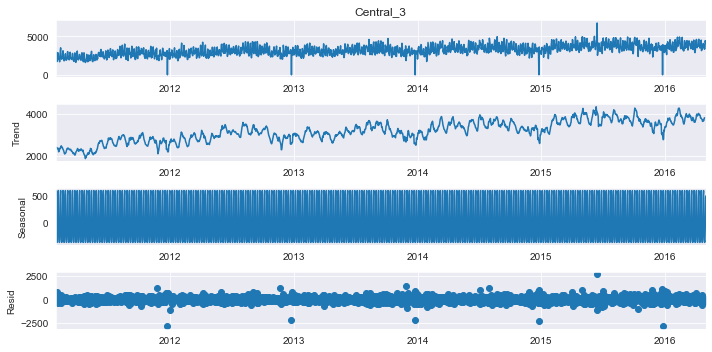

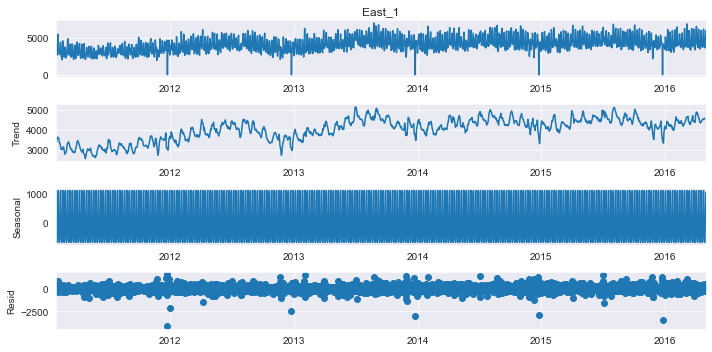

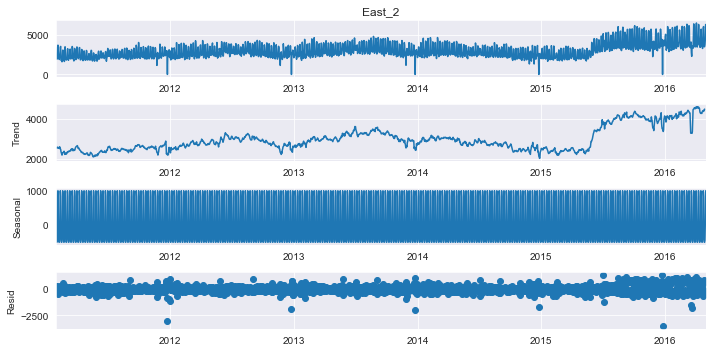

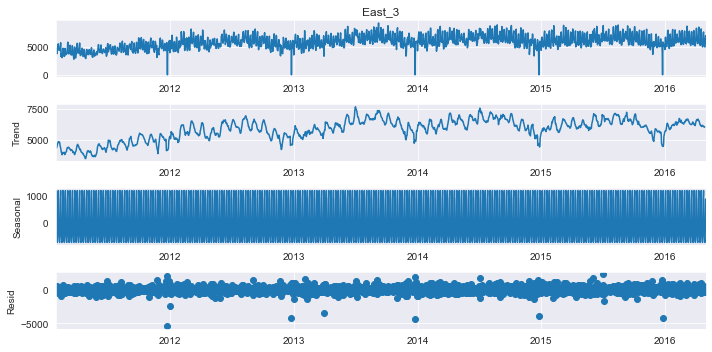

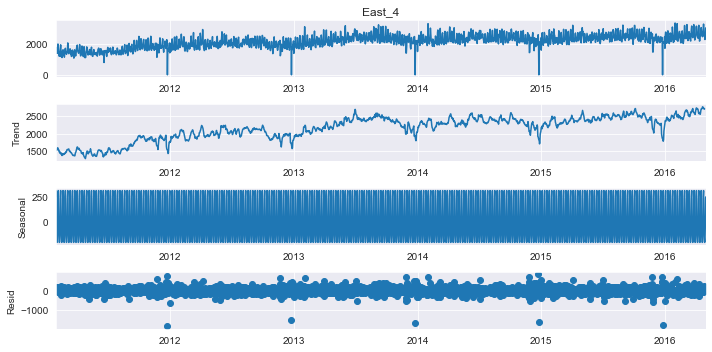

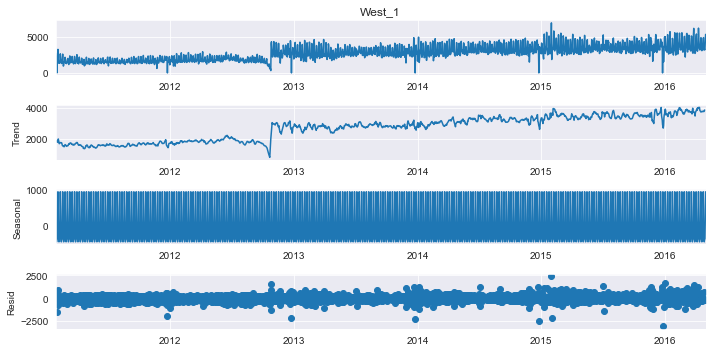

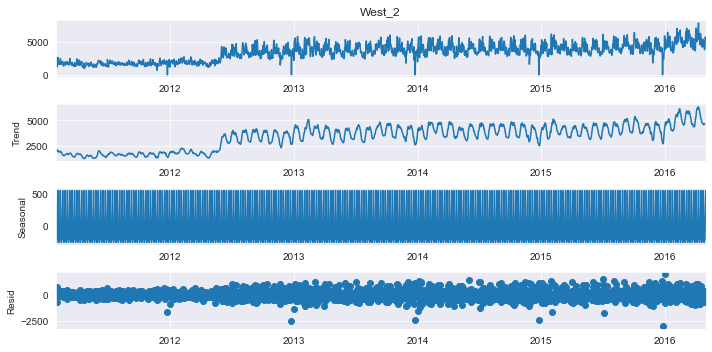

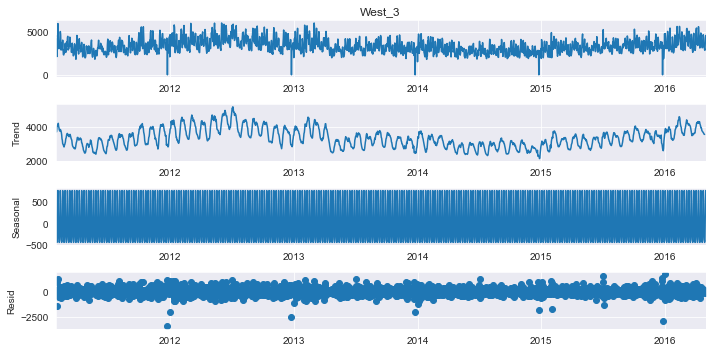

In [15]:
for c in store.columns:
   decomposition = sm.tsa.seasonal_decompose(
      store[c], model="additive")
   decomposition.plot()


We notice that different increasing trends are present in the demand that different stores face. Notably, store 'East_2" seems to have faced a sudden increase in demand after the first half of 2015. This could be due mean the store has expdnaed/absorbed another store/increased in size, or that competitiors might have closed in the area. Similarly,store 'West_1' faces a simiar sudden increase in demand after the third quarter of 2013. It is likely that the store increased its size / restyled, as the demand appears to drop right before this increase, possibly due to the closing of the store for renovations. A similar trend is observable for store 'West_2'. More contextual infomration is needed to fully discern these anomalies and trends.

## Plot ACF & PACF
It's clear that all subcategories and stores have a weekly sales cycle. This is senisble as people often do groceries weekly, or bi weekly, or on their off days from work. 
### By Subcategory

<Figure size 2880x720 with 0 Axes>

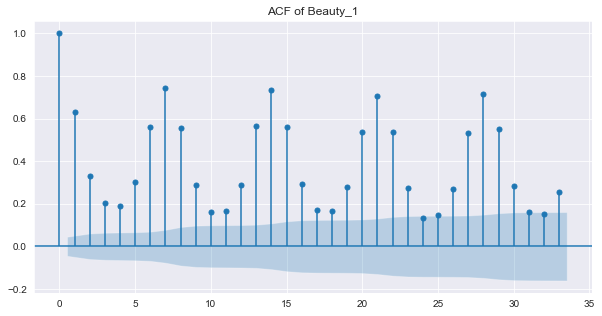

<Figure size 2880x720 with 0 Axes>

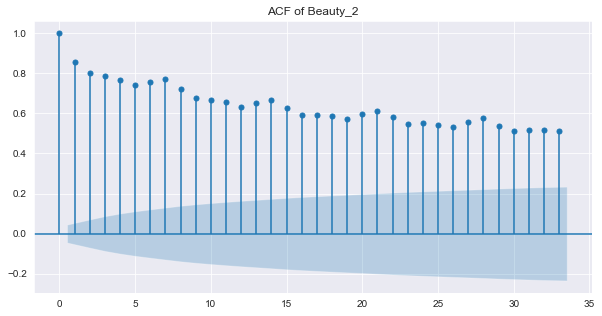

<Figure size 2880x720 with 0 Axes>

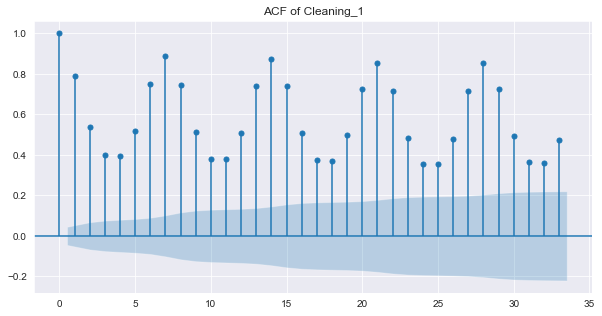

<Figure size 2880x720 with 0 Axes>

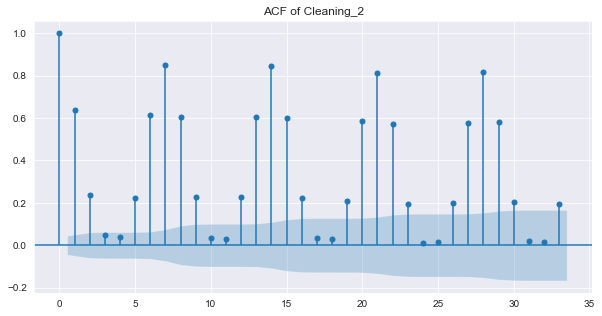

<Figure size 2880x720 with 0 Axes>

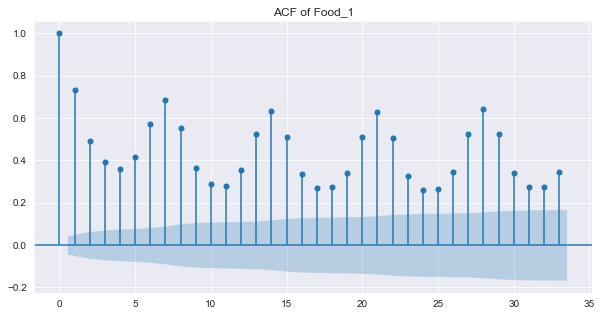

<Figure size 2880x720 with 0 Axes>

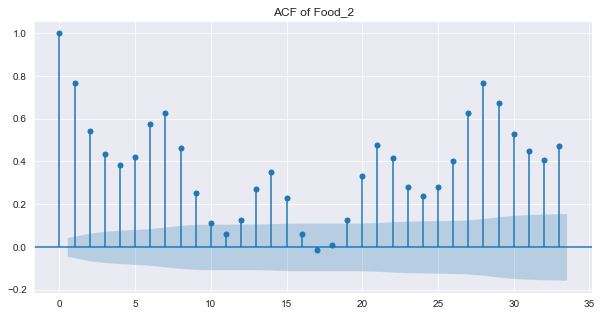

<Figure size 2880x720 with 0 Axes>

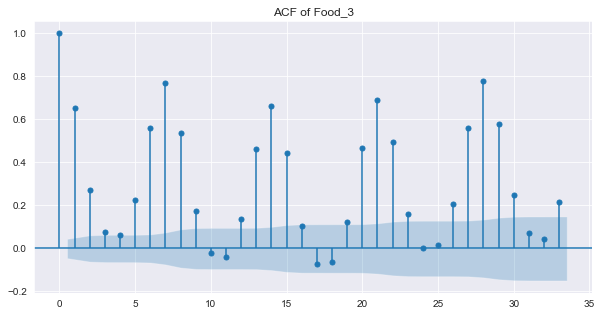

In [16]:
for c in subcat.columns:
    plt.figure(figsize=(40,10))
    plot_acf(subcat[c])
    plt.title(str("ACF of "+c))

<Figure size 2880x720 with 0 Axes>

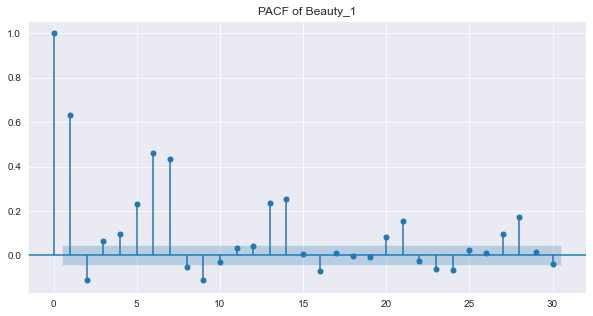

<Figure size 2880x720 with 0 Axes>

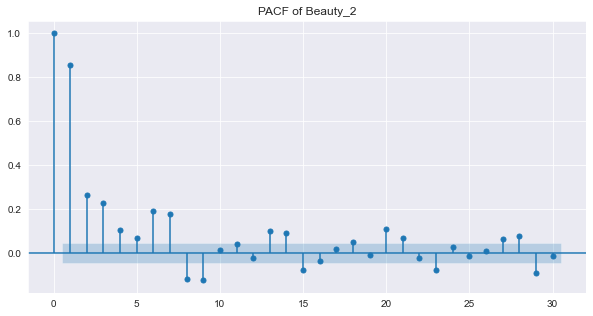

<Figure size 2880x720 with 0 Axes>

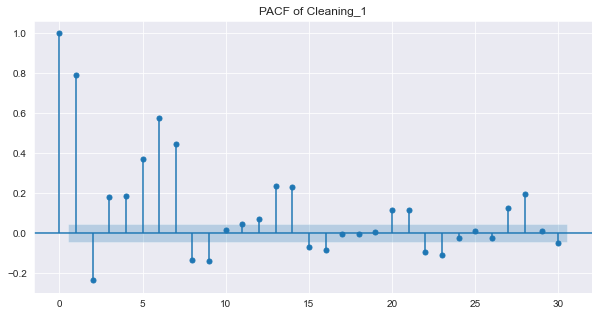

<Figure size 2880x720 with 0 Axes>

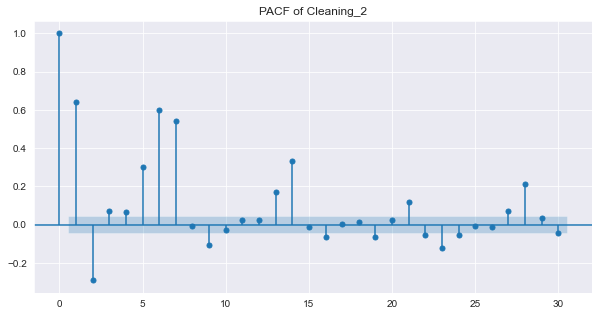

<Figure size 2880x720 with 0 Axes>

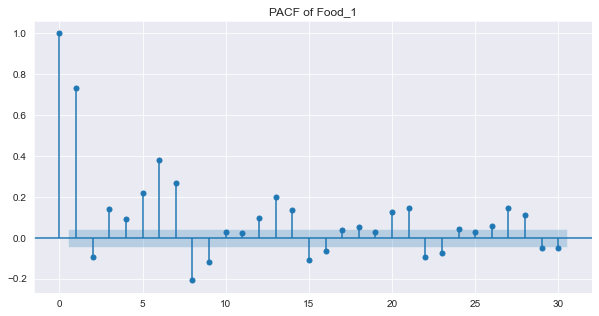

<Figure size 2880x720 with 0 Axes>

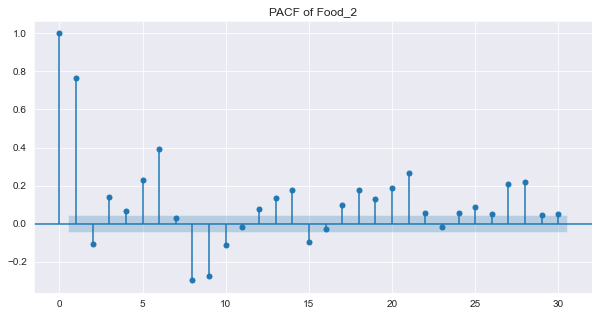

<Figure size 2880x720 with 0 Axes>

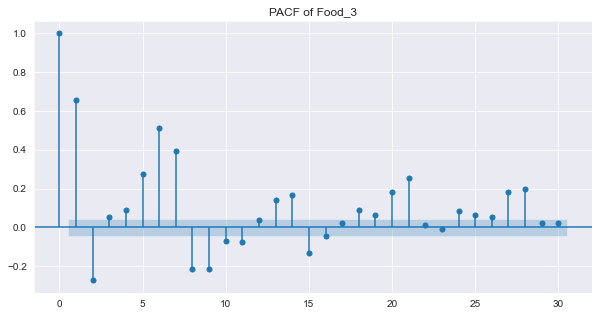

In [17]:
for c in subcat.columns:
    plt.figure(figsize=(40,10))
    plot_pacf(subcat[c], lags=30)
    plt.title(str("PACF of "+c))

/Users/simonegenetin/opt/anaconda3/envs/ysc4224/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<Figure size 2880x720 with 0 Axes>

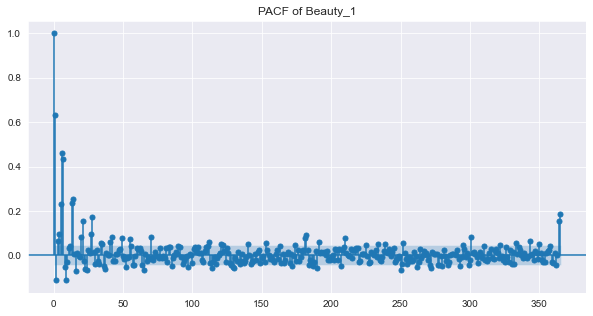

<Figure size 2880x720 with 0 Axes>

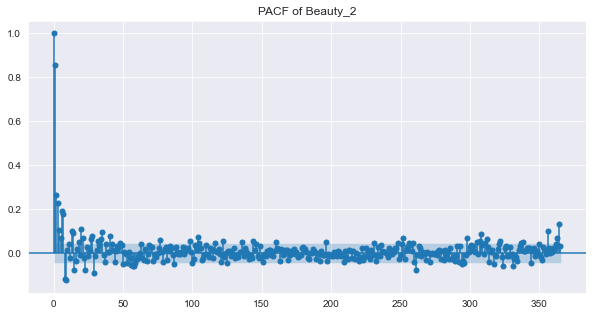

<Figure size 2880x720 with 0 Axes>

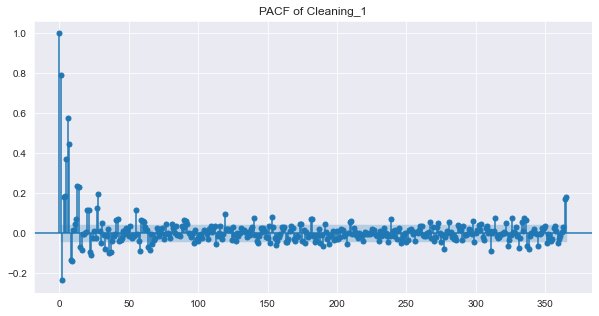

<Figure size 2880x720 with 0 Axes>

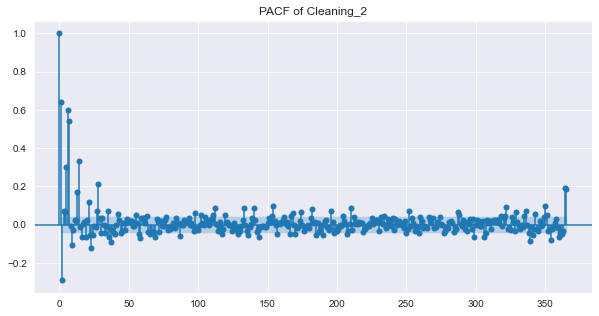

<Figure size 2880x720 with 0 Axes>

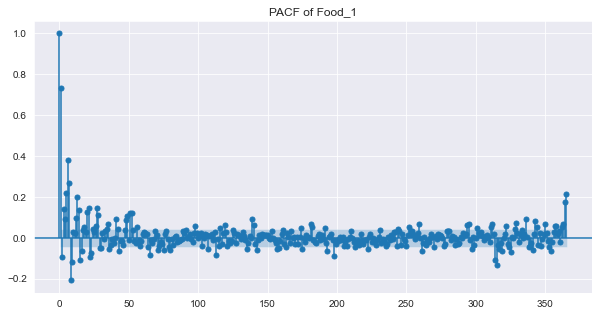

<Figure size 2880x720 with 0 Axes>

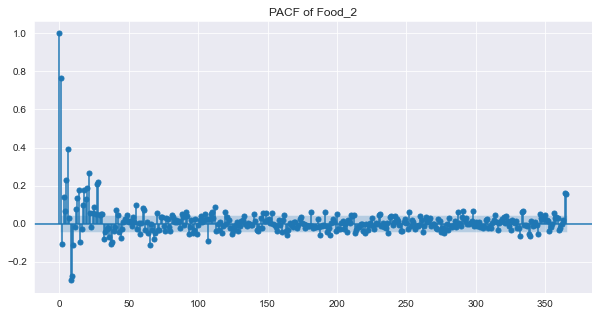

<Figure size 2880x720 with 0 Axes>

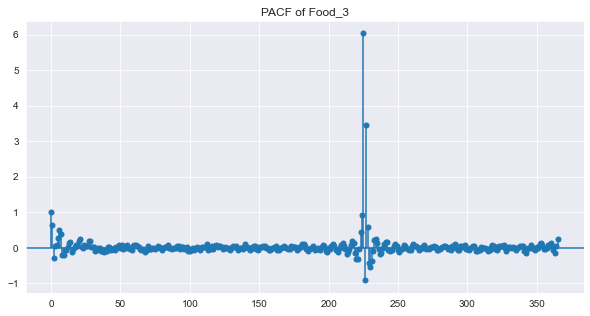

In [20]:
for c in subcat.columns:
    plt.figure(figsize=(40,10))
    plot_pacf(subcat[c], lags=365)
    plt.title(str("PACF of "+c))

Subcategories also have yearly sales cycles, as the above PACF plots show. Tha is clearly due to christmas festivities, when people tend to buy higher quantities of food, and gifts. 

### By Store

We notice that stores face higher demand on weekends.

<Figure size 2880x720 with 0 Axes>

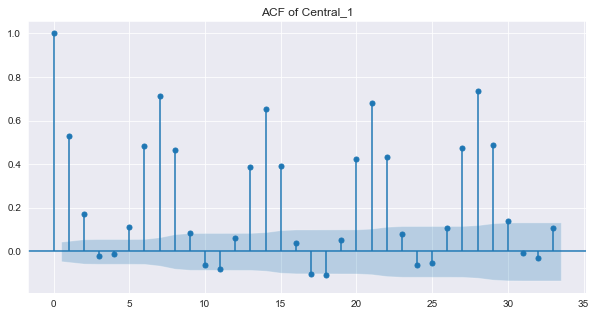

<Figure size 2880x720 with 0 Axes>

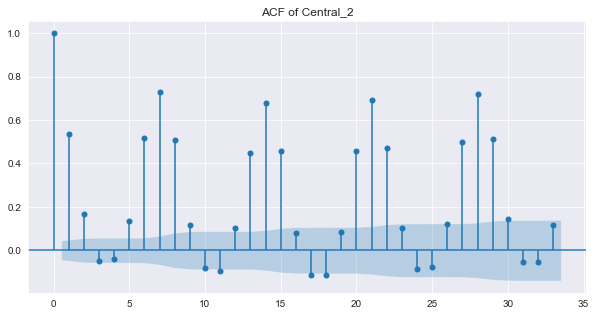

<Figure size 2880x720 with 0 Axes>

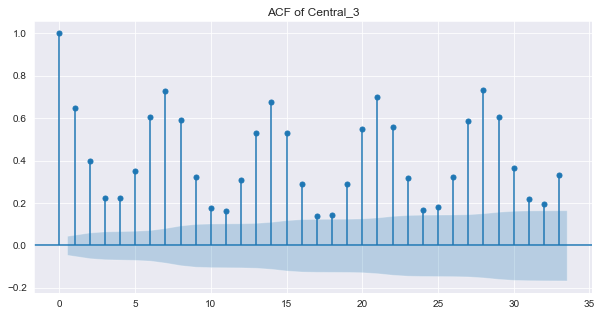

<Figure size 2880x720 with 0 Axes>

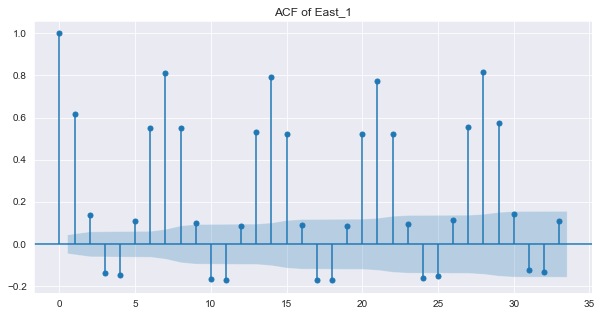

<Figure size 2880x720 with 0 Axes>

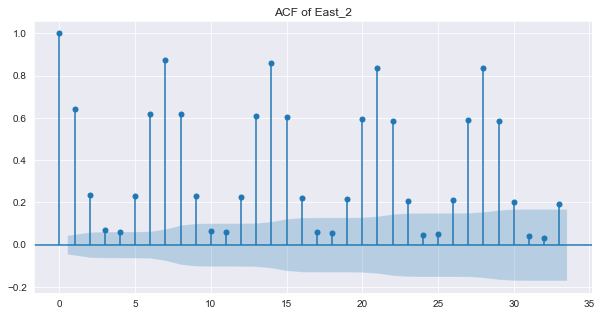

<Figure size 2880x720 with 0 Axes>

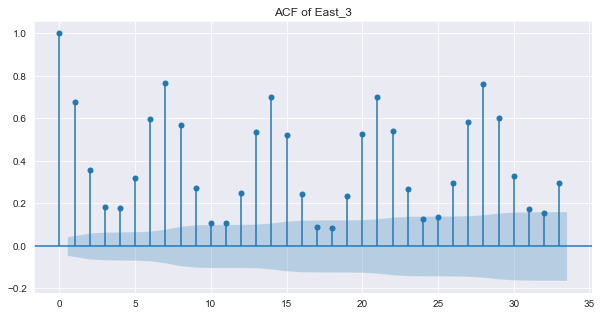

<Figure size 2880x720 with 0 Axes>

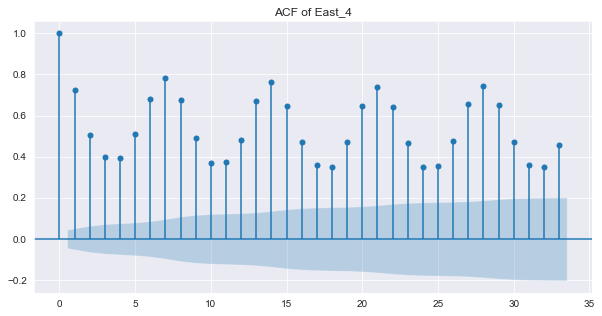

<Figure size 2880x720 with 0 Axes>

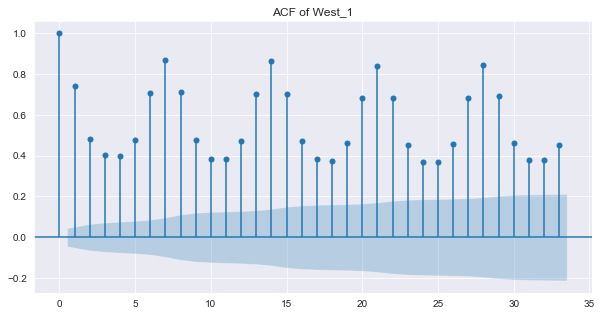

<Figure size 2880x720 with 0 Axes>

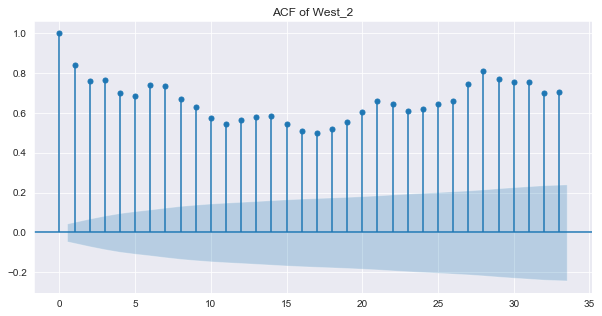

<Figure size 2880x720 with 0 Axes>

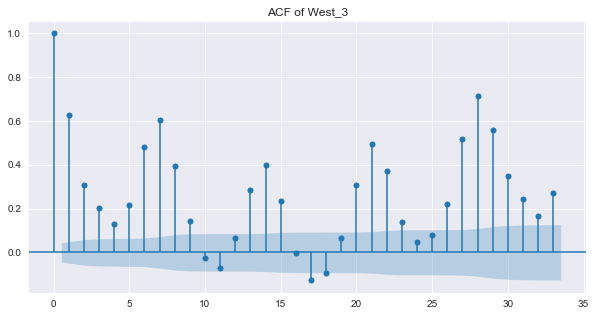

In [18]:
for c in store.columns:
    plt.figure(figsize=(40,10))
    plot_acf(store[c])
    plt.title(str("ACF of "+c))

<Figure size 2880x720 with 0 Axes>

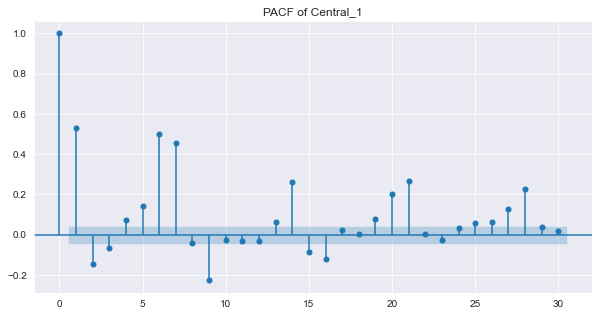

<Figure size 2880x720 with 0 Axes>

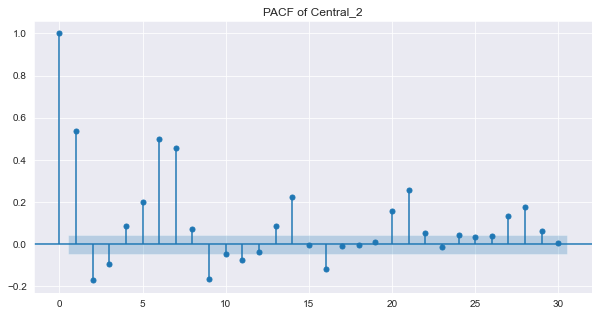

<Figure size 2880x720 with 0 Axes>

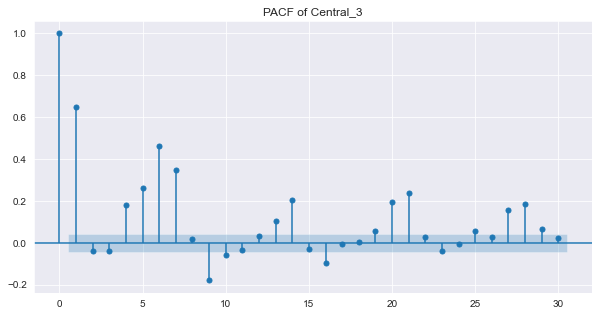

<Figure size 2880x720 with 0 Axes>

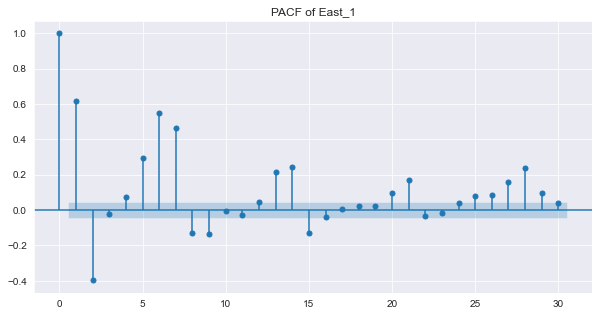

<Figure size 2880x720 with 0 Axes>

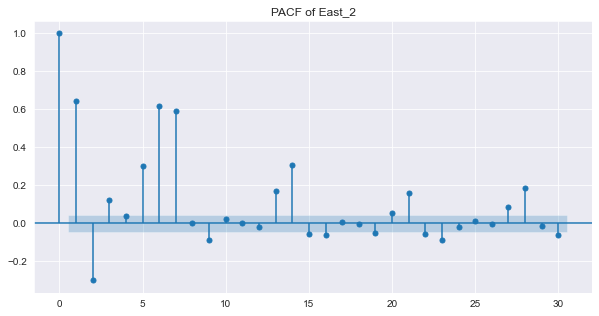

<Figure size 2880x720 with 0 Axes>

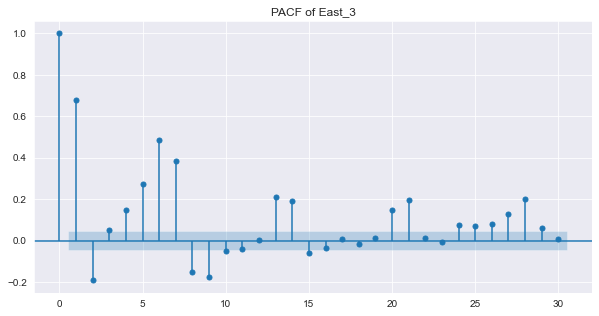

<Figure size 2880x720 with 0 Axes>

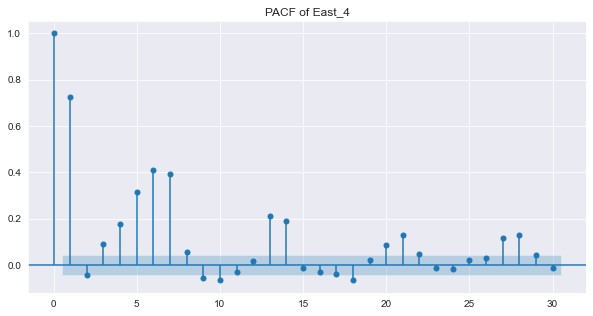

<Figure size 2880x720 with 0 Axes>

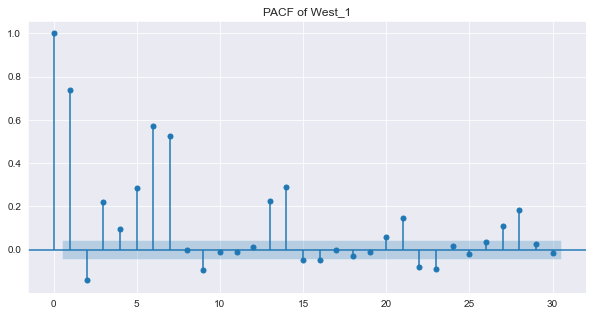

<Figure size 2880x720 with 0 Axes>

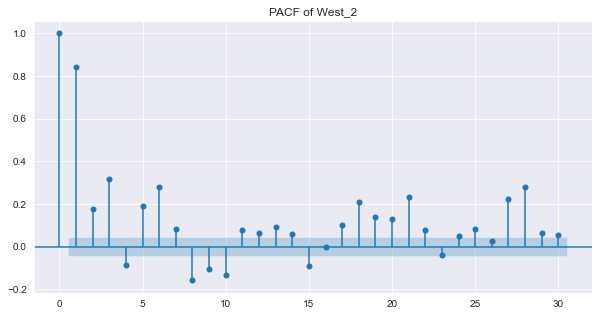

<Figure size 2880x720 with 0 Axes>

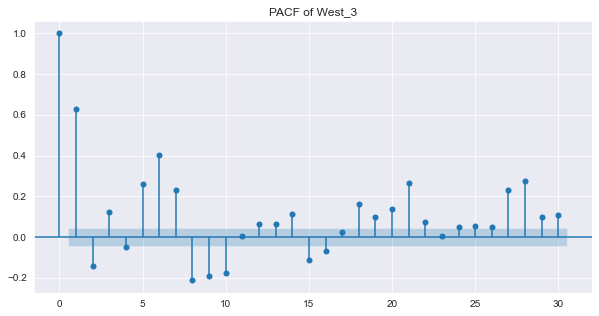

In [19]:
for c in store.columns:
    plt.figure(figsize=(40,10))
    plot_pacf(store[c], lags=30)
    plt.title(str("PACF of "+c))

In [23]:
# xporting to pdf
! pip install nbconvert[webpdf]


SyntaxError: invalid syntax (<ipython-input-23-e83406b3e14d>, line 4)

In [31]:
import nbconvert

jupyter nbconvert --to pdf EDA-2.ipynb

SyntaxError: invalid syntax (<ipython-input-31-6e5450464c4f>, line 3)